<a href="https://colab.research.google.com/github/sdelta/ImageGen/blob/main/check_clip_of_stylegan_grid.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install click requests tqdm pyspng ninja imageio-ffmpeg==0.4.3

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 205.9/205.9 KB 6.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 146.0/146.0 KB 20.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 26.9/26.9 MB 60.3 MB/s eta 0:00:00


In [69]:
!mkdir data

In [70]:
!cp -vf drive/MyDrive/stylegan_finetuning/00038-ffhq-mirror-paper256-kimg1500-resumecustom-freezed10-freezed_mapping/*.png data

'drive/MyDrive/stylegan_finetuning/00038-ffhq-mirror-paper256-kimg1500-resumecustom-freezed10-freezed_mapping/fakes000000.png' -> 'data/fakes000000.png'
'drive/MyDrive/stylegan_finetuning/00038-ffhq-mirror-paper256-kimg1500-resumecustom-freezed10-freezed_mapping/fakes000040.png' -> 'data/fakes000040.png'
'drive/MyDrive/stylegan_finetuning/00038-ffhq-mirror-paper256-kimg1500-resumecustom-freezed10-freezed_mapping/fakes000080.png' -> 'data/fakes000080.png'
'drive/MyDrive/stylegan_finetuning/00038-ffhq-mirror-paper256-kimg1500-resumecustom-freezed10-freezed_mapping/fakes000121.png' -> 'data/fakes000121.png'
'drive/MyDrive/stylegan_finetuning/00038-ffhq-mirror-paper256-kimg1500-resumecustom-freezed10-freezed_mapping/fakes_init.png' -> 'data/fakes_init.png'
'drive/MyDrive/stylegan_finetuning/00038-ffhq-mirror-paper256-kimg1500-resumecustom-freezed10-freezed_mapping/reals.png' -> 'data/reals.png'


In [71]:
!ls data

fakes000000.png  fakes000080.png  fakes_init.png
fakes000040.png  fakes000121.png  reals.png


In [8]:
!pip install open_clip_torch

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 20.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 63.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 63.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 182.4/182.4 KB 19.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.1/53.1 KB 7.6 MB/s eta 0:00:00
  Attempting uninstall: protobuf
    Found existing installation: protobuf 3.19.6
    Uninstalling protobuf-3.19.6:
      Successfully uninstalled protobuf-3.19.6
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow 2.9.2 requires protobuf<3.20,>=3.9.2, but you have protobuf 3.20.3 which is incompatible.
tensorboard 2.9.1 requires protobuf<3.20,>=3.9.2, but you have p

In [9]:
import torch
import open_clip
from PIL import Image
import numpy as np

device = "cuda" if torch.cuda.is_available() else "cpu"
assert device == "cuda"

model, _, preprocess = open_clip.create_model_and_transforms('ViT-B-32-quickgelu', pretrained='laion400m_e32')
tokenizer = open_clip.get_tokenizer('ViT-B-32-quickgelu')

model = model.to(device)

100%|███████████████████████████████████████| 605M/605M [00:12<00:00, 47.9MiB/s]


In [77]:
!ls data

fakes000000.png  fakes000080.png  fakes_init.png
fakes000040.png  fakes000121.png  reals.png


In [92]:
merged_image = Image.open("data/fakes000121.png")

In [93]:
all_images = []

for h_ind in range(merged_image.height // 256):
    for w_ind in range(merged_image.width // 256):
        h_start = h_ind * 256
        w_start = w_ind * 256
        all_images.append(merged_image.crop((w_start, h_start, w_start + 256, h_start + 256)))

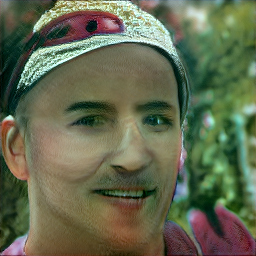

In [94]:
all_images[-1]

In [95]:
src_images = all_images
src_texts = ["glasses"]
images = torch.tensor(np.stack([preprocess(img) for img in src_images])).to(device)
texts = tokenizer(src_texts).to(device)

In [96]:
images.shape

torch.Size([480, 3, 224, 224])

## Building features

We normalize the images, tokenize each text input, and run the forward pass of the model to get the image and text features.

In [97]:
def get_similarities(texts, images):
    with torch.no_grad():
        image_features = model.encode_image(images).float()
        text_features = model.encode_text(texts).float()
    image_features /= image_features.norm(dim=-1, keepdim=True)
    text_features /= text_features.norm(dim=-1, keepdim=True)
    similarity = text_features.cpu().numpy() @ image_features.cpu().numpy().T
    return similarity

In [98]:
get_similarities(texts, images).mean()

0.2416452